<h1>Weater Classification Machine learning Model</h1>
<b>Homework</b>
<p>Use the Data from "weather_Data.csv to create a Machine Learning Model that predicts the Type of wheater</p>
<ol>
Steps
<li>Break up all cathegorial Variables except Weather Type</li>
<lI>Check Distribution</lI>
<li> Try to optimaize, by checking correlation aswell</li>
<li>Create A ANN model</li></ol>

In [223]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# pip install tensorflow
import tensorflow as tf
import keras
from keras import layers

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [224]:
#load Data
df=pd.read_csv("weather_Data.csv")
df.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.00,73,9.50,82.00,partly cloudy,1010.82,2,Winter,3.50,inland,Rainy
1,39.00,96,8.50,71.00,partly cloudy,1011.43,7,Spring,10.00,inland,Cloudy
2,30.00,64,7.00,16.00,clear,1018.72,5,Spring,5.50,mountain,Sunny
3,38.00,83,1.50,82.00,clear,1026.25,7,Spring,1.00,coastal,Sunny
4,27.00,74,17.00,66.00,overcast,990.67,1,Winter,2.50,mountain,Rainy


In [225]:
df.isna().sum()

Temperature             0
Humidity                0
Wind Speed              0
Precipitation (%)       0
Cloud Cover             0
Atmospheric Pressure    0
UV Index                0
Season                  0
Visibility (km)         0
Location                0
Weather Type            0
dtype: int64

In [226]:
df.duplicated().sum()

0

In [227]:
for column in df.columns:
    number_of_distinct_values = len(df[column].unique())
    print(f"{column}: {number_of_distinct_values} distinct values")

Temperature: 126 distinct values
Humidity: 90 distinct values
Wind Speed: 97 distinct values
Precipitation (%): 110 distinct values
Cloud Cover: 4 distinct values
Atmospheric Pressure: 5456 distinct values
UV Index: 15 distinct values
Season: 4 distinct values
Visibility (km): 41 distinct values
Location: 3 distinct values
Weather Type: 4 distinct values


<ul>
<li>Weater Type = 4 Distinc Values , Focus on</li>
<li>Cloud Coverage: 4 Values</li>
<li>Season 4 Values</li>
<li>Location 3 Values</li>
<p>If breaking up all those Values with onehot encoding 5 Columns would be added this is reasonable, but maybe there is a better way, we will check</p>
</ul>

In [228]:
#rename Variables to have no whitespace
df.rename(columns={'Wind Speed': 'WindSpeed'}, inplace=True)
df.rename(columns={'Cloud Cover': 'CloudCover'}, inplace=True)
df.rename(columns={'Atmospheric Pressure': 'Pressure'}, inplace=True)
df.rename(columns={'UV Index': 'UV'}, inplace=True)
df.rename(columns={'Visibility (km)': 'Visibility'}, inplace=True)
df.rename(columns={'Weather Type': 'Type'}, inplace=True)
df.rename(columns={'Precipitation (%)': 'Precipitation'}, inplace=True)

In [229]:
# this makes multiple columns with the variable (Separate for yes/no)
#from sklearn.preprocessing import OneHotEncoder
variables = ['Season']

# use encoder
encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
one_hot_encoded = encoder.fit_transform(df[variables]).astype(int)
df = pd.concat([df,one_hot_encoded],axis=1).drop(columns=variables)
df = df.drop('Season_Autumn', axis=1)
df = df.drop('Location', axis=1)

In [230]:
cloud_cover_mapping = {'clear': 0, 'partly cloudy': 1, 'cloudy': 2, 'overcast': 3}
df['CloudCover_Encoded'] = df['CloudCover'].map(cloud_cover_mapping)
df = df.drop('CloudCover', axis=1)
# Rename the encoded column to CloudCover
df = df.rename(columns={'CloudCover_Encoded': 'CloudCover'})

# Mapping numerical values to descriptive labels for CloudCover
#df['CloudCover'] = df['CloudCover'].replace({0: 'clear', 1: 'partly cloudy', 2: 'cloudy', 3: 'overcast'})




In [231]:
df.head()

,Temperature,Humidity,WindSpeed,Precipitation,Pressure,UV,Visibility,Type,Season_Spring,Season_Summer,Season_Winter,CloudCover
0,14.00,73,9.50,82.00,1010.82,2,3.50,Rainy,0,0,1,1
1,39.00,96,8.50,71.00,1011.43,7,10.00,Cloudy,1,0,0,1
2,30.00,64,7.00,16.00,1018.72,5,5.50,Sunny,1,0,0,0
3,38.00,83,1.50,82.00,1026.25,7,1.00,Sunny,1,0,0,0
4,27.00,74,17.00,66.00,990.67,1,2.50,Rainy,0,0,1,3


<h4>X/Y</h4>

In [232]:
# everything else except the target variable
X = df.drop(["Type"], axis=1)

# have only the target variable here (dependent variable)
y_temp = df['Type']

# since we are doing classification, we have to process our target values with an encoder
# and convert them into a categorical TensorFlow/Keras -format 
le = LabelEncoder()
y_enc = le.fit_transform(y_temp)

# Converting the label into a matrix form
y = tf.keras.utils.to_categorical(y_enc)

#seperate df for the corr function
yf=df
yf['Type']=y_enc

<h3>Analytic</h3>
<p>I will shamelessly just use the Reports.ipynb file from the AdDA HW again to get some basic stats</p>

In [233]:
df['Type'].value_counts().sort_index()


Type
0    3300
1    3300
2    3300
3    3300
Name: count, dtype: int64

<p>Every Typ has Exactly 3300 this does look like artifically made Data, but also means there is no need for grouping</p>

<b>Quick checklist</b>
<ol><li>Correlation</li><LI>Distribution</LI><li>Outliers</li></ol>

In [234]:
correlations=df.corr()['Type']
correlations.sort_values(ascending=False)

Type             1.00
UV               0.35
Season_Winter    0.14
Visibility       0.05
Pressure         0.03
Temperature      0.03
Season_Summer   -0.05
Season_Spring   -0.07
Precipitation   -0.16
WindSpeed       -0.17
Humidity        -0.25
CloudCover      -0.37
Name: Type, dtype: float64

<b>Under 0.0 (excpet onehot encoded)</b>
<ul>
<li>Visibility</li>
<li>Pressure</li>
<li>Temperatur</li>
</ul>

<b>Fisher's lowest</b>
<ul><li>Humidity</li><li>Cloud_Cover</li><li>Precepitation</li></ul>

<b>Phik Max</b>
<ul><li>Temp</li><li>Precipitation</li><li>Cloud cover</li></ul>

<p>So basically all test say oposite thigns fuck</p>

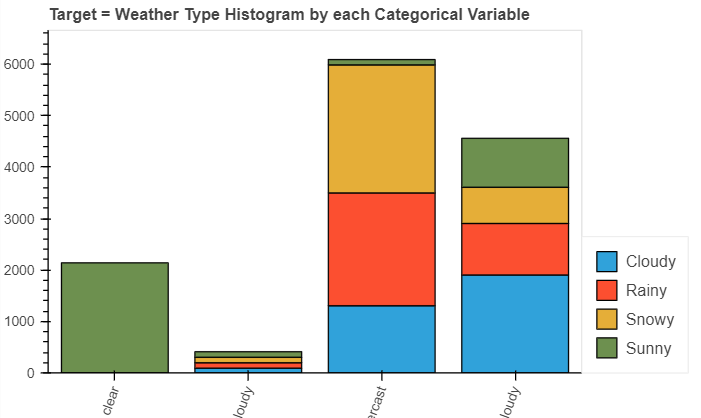
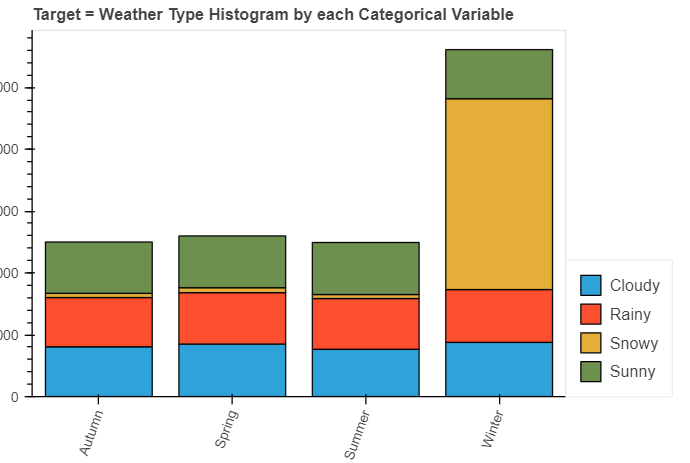
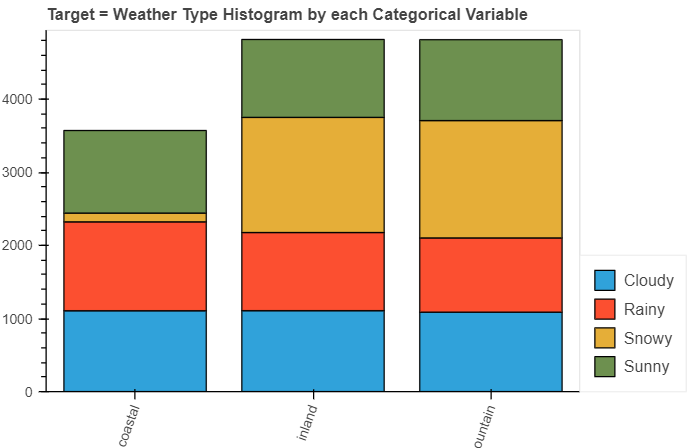
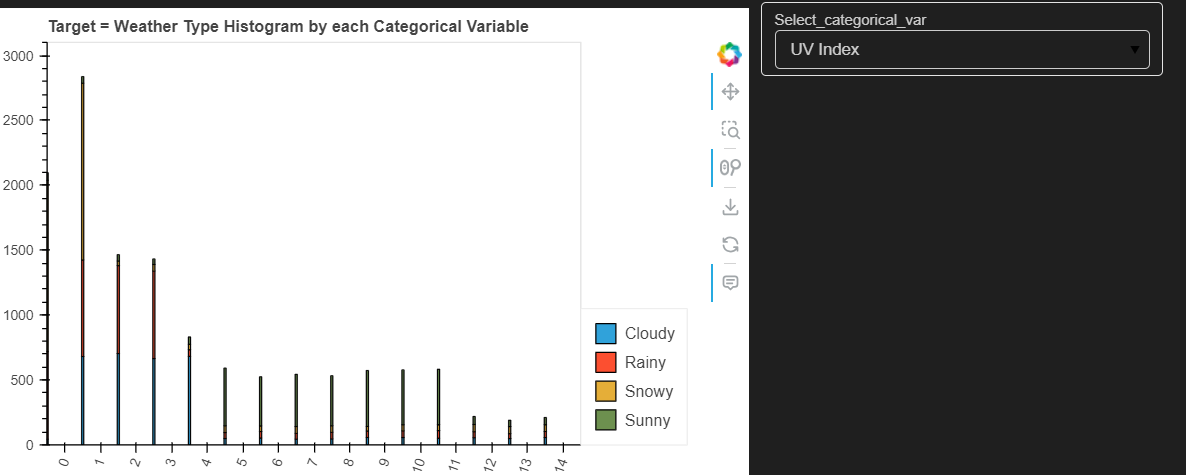

<p>It sems there are no observations during cloudy weater, maybe remove</p>
<p>During winter its only snowy</p>
<p>On costal its not snowy ever</p>
<p>Maye group uv</p>

In [235]:
df['UV'].value_counts().sort_index()
# you could group below 500, aka 12,13,14

#pissible grouping:
#1
#2
#3
#4
#5-6
#7-8
#9-10
#11-14

UV
0     2097
1     2837
2     1465
3     1432
4      831
5      591
6      524
7      543
8      532
9      572
10     577
11     582
12     218
13     189
14     210
Name: count, dtype: int64

In [236]:
df['UV'] = df['UV'].replace({14: 13})
df['UV'] = df['UV'].replace({13:12})
df['UV'] = df['UV'].replace({12:11})
df['UV'] = df['UV'].replace({10:9})
df['UV'] = df['UV'].replace({7:8})
df['UV'] = df['UV'].replace({6:5})
df['UV'].value_counts().sort_index()

UV
0     2097
1     2837
2     1465
3     1432
4      831
5     1115
8     1075
9     1149
11    1199
Name: count, dtype: int64

In [237]:
#clarity Renaming
df['UV'] = df['UV'].replace({11:12, 9:10,8:7,5:6})
df['UV'].value_counts().sort_index()

UV
0     2097
1     2837
2     1465
3     1432
4      831
6     1115
7     1075
10    1149
12    1199
Name: count, dtype: int64

In [238]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# convert all continuous variables to integer,
# and convert all negative numbers to 0
X_cat = X.astype(int)
X_cat = X_cat.clip(lower=0)

# initialize chi2 and SelectKBest
# Note: chi2 -test is a very common test
# in statistics and quantitative analysis
# basically it studies the data whether variables are related
# or independent of each other
chi_2_features = SelectKBest(chi2, k=len(X_cat.columns))

# fit our data to the SelectKBest
best_features = chi_2_features.fit(X_cat,y.astype(int))

# use decimal format in table print later
pd.options.display.float_format = '{:.2f}'.format

# wrap it up, and show the results
# the higher the score, the more effect that column has on price
df_features = pd.DataFrame(best_features.scores_)
df_columns = pd.DataFrame(X_cat.columns)
f_scores = pd.concat([df_columns,df_features],axis=1)
f_scores.columns = ['Features','Score']
f_scores.sort_values(by='Score',ascending=False)

,Features,Score
3,Precipitation,116004.26
0,Temperature,80224.59
1,Humidity,23729.09
5,UV,16954.11
2,WindSpeed,10952.57
6,Visibility,8754.33
10,CloudCover,4963.69
9,Season_Winter,2697.12
4,Pressure,1270.05
8,Season_Summer,671.18


<p>According to here Season is Rather unimportant, but that cant be because snow is only in winter</p>

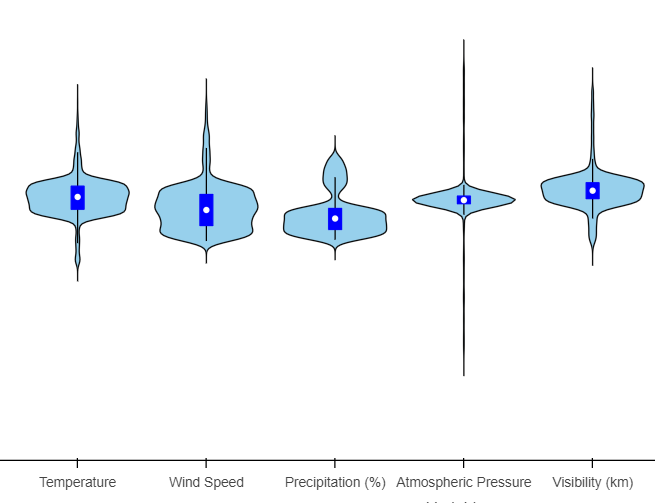

<b>Distribution</b>
<p>Trying to Cap Distribution</p>

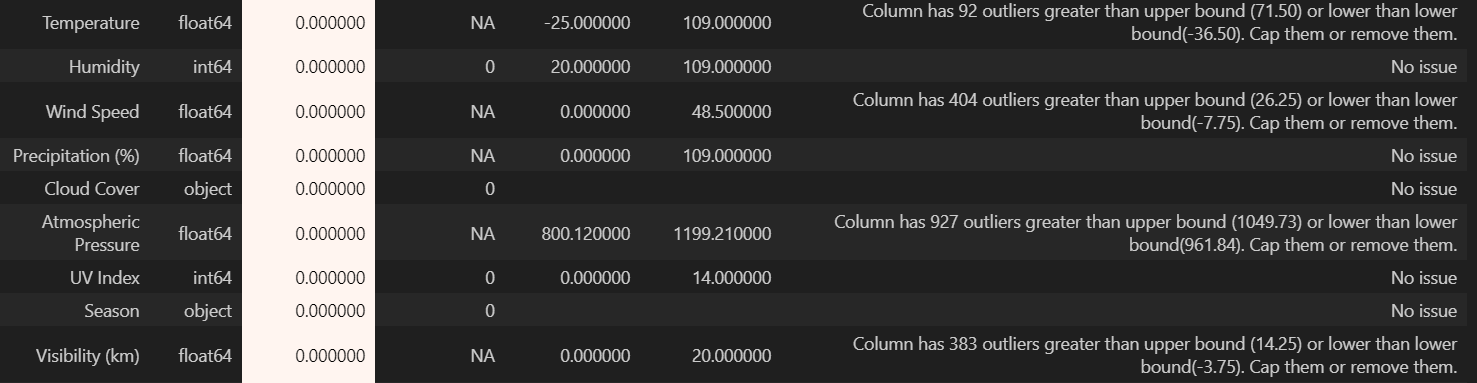

In [239]:
# Capping outliers for each column with specific bounds
df['Temperature'] = df['Temperature'].clip(lower=-36.50, upper=71.50)
df['WindSpeed'] = df['WindSpeed'].clip(lower=-7.75, upper=26.25)
df['Pressure'] = df['Pressure'].clip(lower=962, upper=1049)
df['Visibility'] = df['Visibility'].clip(lower=-3.75, upper=14.25)



<p>Since this homework is mainly about testing, messing and finding out, I will make a 1 to 1 Copy of tis file, but safe the current df, just to see if all the cleaing changed anything for the correlations, without cluttering this file (so check CLass_test)</p>

In [240]:
#df.to_csv('weatherer.csv', index=False)

<b>Diff:</b>
<ul>
<li>I Removed the onehot encoding to have a clearer view on the analysis, things that are important to note:</li>
<ul><li>40% of the Recorded Data are made in winter, Spring summer and Autum all have around the same % and its about 17%</li>
<li>Cloud cover : 46% of the data is "overcast"</li>
<li>Location have 36% of the values in inland and mountain, but only 27% in coastel</li></ul>
<li>type has a high corr with Temp and Precipation,UV and Visibility</li>
<li>Low with Location and Season</li>
<li>uv has around 55% of the values in 0-3</li></ul>
<b>Sum</b>
<ul>
<li>If you are reading this: i will have dropped Location</li></ul>

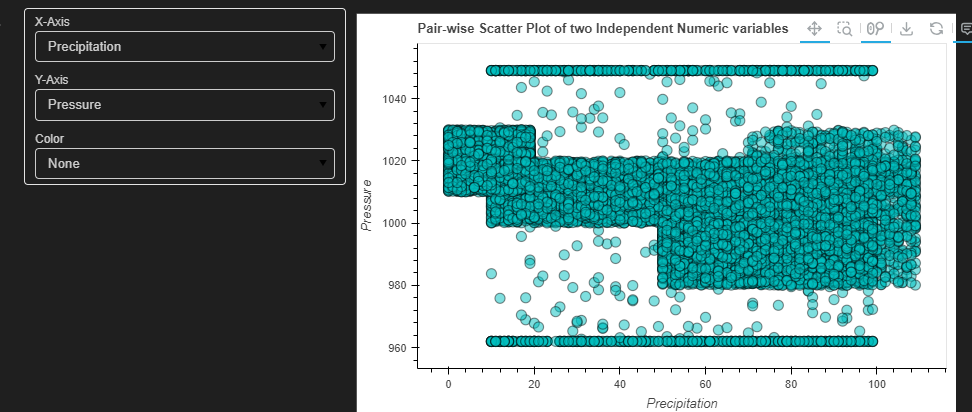

<p>Its very visible that when certain columns reach certain values, theyfall into these blocks</p>

<h2>Model</h2>
<p>Since this is not hw1 anymore, i will try to use the more complex model with the worked on data from the beginning, and just show my progess there </p>

In [241]:
#X/Y already was done before so only training split remains
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

In [244]:
categories = list(np.unique(df['Type']))
print(categories)

[0, 1, 2, 3]


In [245]:
model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(len(X.columns),)),
        layers.Dense(16, activation="relu", kernel_regularizer=keras.regularizers.l1(l1=0.1)),
        layers.Dense(8, activation="relu"),
        layers.Dense(len(categories),activation="softmax")
    ]
)

# compile the model, this time we use categorical crossentropy for loss -function
# and we also measure the accuracy of our model in the metrics
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\janni\OneDrive\DeepLAdDA\.venv\lib\site-packages\keras\src\layers\normalization\batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_1           │ (None, 11)             │            44 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 408 (1.59 KB)

 Trainable params: 386 (1.51 KB)

 Non-trainable params: 22 (88.00 B)

<b>1. Run model:</b>
<p>model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(len(X.columns),)),
        layers.Dense(16, activation="relu", kernel_regularizer=keras.regularizers.l1(l1=0.1)),
        layers.Dense(8, activation="relu"),
        layers.Dense(len(categories),activation="softmax")
    ]
)

# compile the model, this time we use categorical crossentropy for loss -function
# and we also measure the accuracy of our model in the metrics
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()</p>

In [246]:
# adjust epochs as you see fit
model.fit(x=X_train, y=y_train, epochs=500, validation_data=(X_val, y_val))

Epoch 1/500
289/289 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4793 - loss: 4.3832 - val_accuracy: 0.7530 - val_loss: 1.6844
Epoch 2/500
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8068 - loss: 1.3114 - val_accuracy: 0.8737 - val_loss: 0.8195
Epoch 3/500
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8489 - loss: 0.7985 - val_accuracy: 0.8773 - val_loss: 0.7097
Epoch 4/500
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8476 - loss: 0.7226 - val_accuracy: 0.8828 - val_loss: 0.6539
Epoch 5/500
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8595 - loss: 0.6661 - val_accuracy: 0.8793 - val_loss: 0.6195
Epoch 6/500
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8661 - loss: 0.6297 - val_accuracy: 0.8763 - val_loss: 0.6012
Epoch 7/500
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8575 - loss: 0.6108 - val_accuracy: 0.8833 - val_loss: 0.5885
Epoch 8/500
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8693 - loss: 0.6035 - val_accu

<h4> Standard Tests</h4>
<p>The way i will order this here is: <ol><li>Code block chunks for the test</li><li>Markdown Field's for the rsults</li><li>Screenshots of the graphs for legacy</li><li>repeat</li></ol><br>
Each Legacy Markdown will be numbered but only as "noteworthy" (i.e. for example if in the 2. run nothing noteworthy happens it will not be written down, so number 2 is maybe the 5th run etc) I think it is not usefull to write down how many runs a noteworthy result took</p>

<h4>1. Loss</h4>

<Axes: >

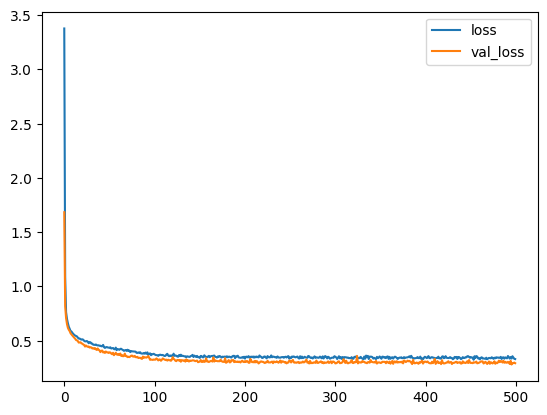

In [247]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

<Axes: >

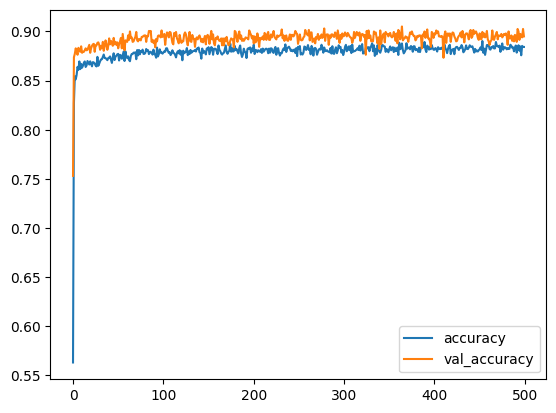

In [248]:
loss_df[['accuracy', 'val_accuracy']].plot()

In [249]:
# the values should again match mostly
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
[0.29749035835266113, 0.8969696760177612]

Train data evaluation:
[0.27156051993370056, 0.9096320271492004]


<ul><b>Notes</b>
<li>1. Run <ul>
<li><p>For once in my hw life an actual normal looking loss function <br> when comparing the Tst and Train data evaluation the results are similar, the magnituude is below 0.3, wich means its somewhat precice , and at least not extremly off</p></li>
<li>There seems to be no signs of over or under fitting... but</li>
<li>After around epoch 150 the val loss and the loss seem to stagnate and stay pretty similar, they stop geting better or worse</li>
</ul></li>
<li>2. Run <ul>

</ul></li>
<li>3. Run <ul>

</ul></li>


</ul>


<b>Sceenshots 1.</b>

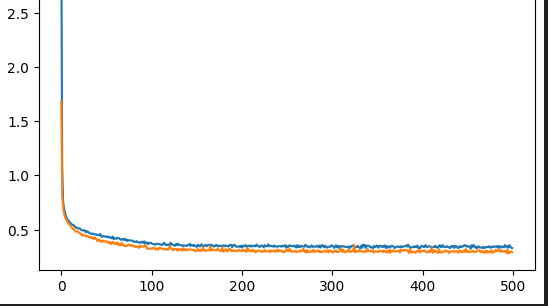
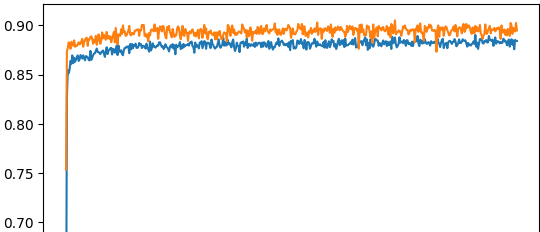

<h4>2. Matrix</h4>

In [250]:
# get predictions and convert with argmax() to get categories 
# instead of raw probabilities
test_predictions = model.predict(X_test)
test_predictions = np.argmax(test_predictions, axis=1)

# convert also y-test -values with argmax
y_test = np.argmax(y_test, axis=1)

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


<Axes: >

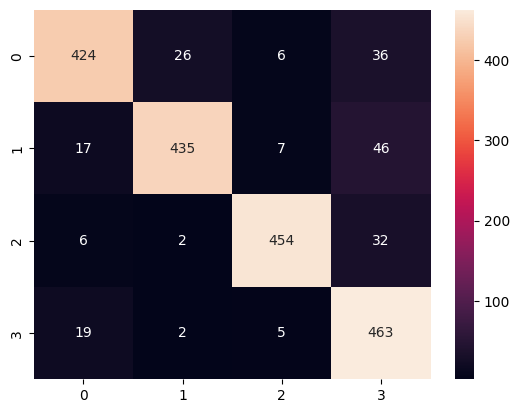

In [251]:
# confusion matrix
sns.heatmap(confusion_matrix(y_test, test_predictions),xticklabels=categories,yticklabels=categories, annot=True, fmt='g')

In [252]:
# print the classification report based on true values and predictions
print(classification_report(y_test, test_predictions))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

           0       0.91      0.86      0.89       492
           1       0.94      0.86      0.90       505
           2       0.96      0.92      0.94       494
           3       0.80      0.95      0.87       489

    accuracy                           0.90      1980
   macro avg       0.90      0.90      0.90      1980
weighted avg       0.90      0.90      0.90      1980


Model overall accuracy: 89.70%


<ul><b>Notes</b>
<li>1. Run <ul>
<li><p>Most of the Conusion Matrix seems to be correct, but the amount offalse positivs and false negatives are not the same, there is a clear tendency for Overclassifying class 0, 1, and 2 as class 3 <br> Also clasifying class 3 as class 0, other than that everythign seems to be expected</p></li>
<li>Overall: <ul><li>Precicion: for all clases over 90%</li> <li>Recall: for 0 and 1 its 0.86 other than that over90, wich is still pretty good</li><li>F1: very precice, but here its to not that 1,2 are the most precice while 0, 4 are below 90</li>
<li>Overall accuracy 89% wich is very good, but has room for improvement</li></ul></li>
</ul></li>
<li>2. Run <ul>

</ul></li>
<li>3. Run <ul>

</ul></li>


</ul>

<b>Screenshots for chap 2 run 1</b>

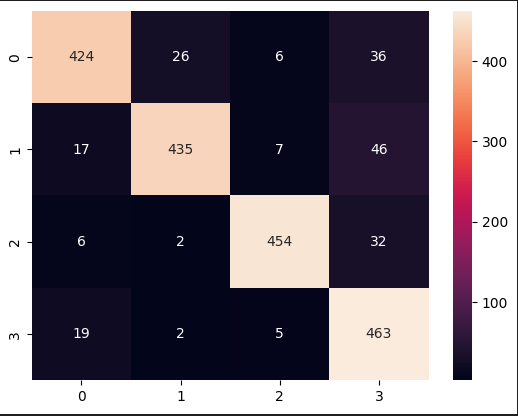

<h4>AOC and Test</h4>

In [253]:
# The AUC score is a super sensitive metric
# you often get low scores, even 0.5

# in binary classification, AUC values are often interpreted as follows:
# A binary classifier is useful only when it achieves ROC-AUC score greater than 0.5 and as near to 1 as possible. 
# If a classifier yields a score less than 0.5, it simply means that the model is performing worse 
# than a random classifier, and therefore is useless.

# In multi category classification , AUC values are often interpreted as follows: 
# 0.5-0.6 (failed)
# 0.6-0.7 (worthless)
# 0.7-0.8 (poor)
# 0.8-0.9 (good)
# > 0.9 (excellent)

# get ROC-AUC -score
roc_auc_score(y, model.predict(X), multi_class="ovr")

413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


0.9910105984083257

In [254]:
X.columns

Index(['Temperature', 'Humidity', 'WindSpeed', 'Precipitation', 'Pressure',
       'UV', 'Visibility', 'Season_Spring', 'Season_Summer', 'Season_Winter',
       'CloudCover'],
      dtype='object')

In [255]:
X.head()

,Temperature,Humidity,WindSpeed,Precipitation,Pressure,UV,Visibility,Season_Spring,Season_Summer,Season_Winter,CloudCover
0,14.00,73,9.50,82.00,1010.82,2,3.50,0,0,1,1
1,39.00,96,8.50,71.00,1011.43,7,10.00,1,0,0,1
2,30.00,64,7.00,16.00,1018.72,5,5.50,1,0,0,0
3,38.00,83,1.50,82.00,1026.25,7,1.00,1,0,0,0
4,27.00,74,17.00,66.00,990.67,1,2.50,0,0,1,3


In [259]:
# let's try with some new imaginary data
# modify this as needed regarding your own dataset
tester_row = {
    'Temperature': 20.00, 
    'Humidity': 70,
    'WindSpeed': 2.00, 
    'Precipitation':66.50,
    'Pressure': 1000.00,
    'UV': 3,
    'Visibility': 3.80,
    'Season_Spring': 1,
    'Season_Summer': 0, 
    'Season_Winter':  0,
    'CloudCover': 2
}

# convert to pandas-format
tester_row = pd.DataFrame([tester_row])
result = model.predict(tester_row)[0]
result_text = categories[np.argmax(result)]

#'clear': 0, 'partly cloudy': 1, 'cloudy': 2, 'overcast': 3
print("-> 0 Sunny, 3 Overcast")
print(f"Predicted Weater: {result_text}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
-> 0 Sunny, 3 Overcast
Predicted Weater: 1


<ul><b>Notes</b>
<li>1. Run <ul>
<li>AOC = 0.991 = Perfect score this means this model is way way way better than just randomly guessing </li> <li>Predicted Weater for test data: 'partly clouded'</li>
<li>Summary: Already very good, imma try to make the Modell a bit more complex to see what happens, i think ill overly complexify the odell andadd a drop layer, so i can check in the future what happens to then slowly break it down (the engineers way)</li>
</ul></li>
<li>2. Run <ul>

</ul></li>
<li>3. Run <ul>

</ul></li>


</ul>